# 📻 Klasifikasi Genre Gamelan dengan ConvLSTM



#1. Instalasi Library


In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import noisereduce as nr
import joblib
import json
import IPython.display as ipd
from datetime import datetime
import tensorflow as tf
from scipy import signal
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

## 3. Set Paths & Hyperparameters


In [3]:
#Memastikan konsistensi data
seed_value = 42 

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Paths
train_dir = "E:/RISVA/audio_model/dataset/segmentation_10s/train/"
val_dir = "E:/RISVA/audio_model/dataset/segmentation_10s/validation/"
save_model_dir = "E:/RISVA/audio_model/model_logs/V13_fix_ast"
os.makedirs(save_model_dir, exist_ok=True)

# Audio parameters
SR = 22050
DURATION = 10
N_FFT = 1024
HOP_LENGTH = 512

# Model parameters
N_MFCC = 40
MAX_PAD_LEN = 432
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-4
L2_REG = 1e-4

# # Denoising parameters
# NOISE_REDUCTION_PARAMS = {
#     'stationary': True,
#     'prop_decrease': 0.9,
#     'n_fft': N_FFT,
#     'win_length': HOP_LENGTH
# }



#4. Denoising, Augmentasi, & Ekstraksi Fitur

In [4]:
#Denoising
def denoise_audio(y, sr):
    # 1. Deteksi noise dari bagian non-aktif
    energy = librosa.feature.rms(y=y)
    frames = np.where(energy < np.percentile(energy, 10))[0]
    noise_samples = y[frames]


    # --- Versi Perbaikan ---
    GAMELAN_NR_PARAMS = {
        'stationary': False,
        'prop_decrease': 0.30,  
        'n_fft': N_FFT,       
        'win_length': N_FFT,  
        'hop_length': N_FFT // 4,
        'use_tqdm': False
    }
    return nr.reduce_noise(
        y=y,
        y_noise=noise_samples,
        sr=sr,
        **GAMELAN_NR_PARAMS
    )


In [5]:
def gamelan_style_augmentation(y, sr):
    prob = 0.5  # Probabilitas tiap augmentasi

    if random.random() < prob:
        y = tempo_preserve_pitch(y, sr)

    if random.random() < prob:
        y = gamelan_pitch_shift(y, sr)

    if random.random() < prob:
        y = dynamic_range_augmentation(y)

    if random.random() < prob:
        y = cyclic_rhythm_crop(y, sr)

    return y


def tempo_preserve_pitch(y, sr):
    rate = np.random.choice([0.9, 1.0, 1.1])
    y = librosa.effects.time_stretch(y, rate=rate)
    return y


def gamelan_pitch_shift(y, sr):
    steps = np.random.choice([-0.25, 0, 0.25])
    y = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
    return y


def dynamic_range_augmentation(y, sr=None):
    if np.random.rand() > 0.5:
        y = signal.lfilter([1, 0.5], [1], y)
    else:
        y = librosa.util.normalize(y) * 0.8
    return y


def cyclic_rhythm_crop(y, sr):
    cycle_duration = np.random.uniform(6, 8)
    samples = int(cycle_duration * sr)
    if len(y) > samples:
        start = np.random.randint(0, len(y) - samples)
        y = y[start:start+samples]
    return y

In [6]:
def extract_features(y, sr, augment=True):
    # Denoising
    y_clean = denoise_audio(y, sr)
    try:
        # Augmentasi
        if augment:
            y = gamelan_style_augmentation(y_clean, sr)
        else:
            y = y_clean

        # Ekstraksi fitur
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40,n_fft=2048, hop_length=512)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

        # Gabungkan fitur
        features = np.vstack([mfcc, spectral_contrast, chroma])

        # Normalisasi per fitur
        features = (features - np.mean(features, axis=1, keepdims=True)) / \
                   (np.std(features, axis=1, keepdims=True) + 1e-6)

        # Padding
        if features.shape[1] < MAX_PAD_LEN:
            n_repeats = int(np.ceil(MAX_PAD_LEN / features.shape[1]))
            features = np.tile(features, n_repeats)[:, :MAX_PAD_LEN]
        else:
            features = features[:, :MAX_PAD_LEN]

        return features.T.reshape(MAX_PAD_LEN, features.shape[0], 1, 1)

    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        return None

# 5. Load Dataset & Visualisasi

In [7]:
def load_dataset(directory, augment=True):
    X = []
    y = []
    classes = sorted(os.listdir(directory))

    for cls in classes:
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue

        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.wav', '.mp3'))]

        for fn in tqdm(files, desc=f"Loading {cls}"):
            try:
                # Load audio
                y_audio, sr = librosa.load(os.path.join(cls_path, fn), sr=SR)

                # Denoising
                y_clean = nr.reduce_noise(
                    y=y_audio,
                    sr=SR,
                    y_noise=y_audio[:int(0.3*SR)] if len(y_audio) > int(0.3*SR) else y_audio,
                    prop_decrease=0.85
                )

                # Ekstraksi fitur
                features = extract_features(y_clean, sr, augment=augment)

                # Append ke list
                X.append(features)
                y.append(cls)

            except Exception as e:
                print(f"Error processing {fn}: {str(e)}")
                continue

    return np.array(X), np.array(y)  # Konversi ke array di akhir

Visualisasi Proses Preprocessing:
Berhasil disimpan


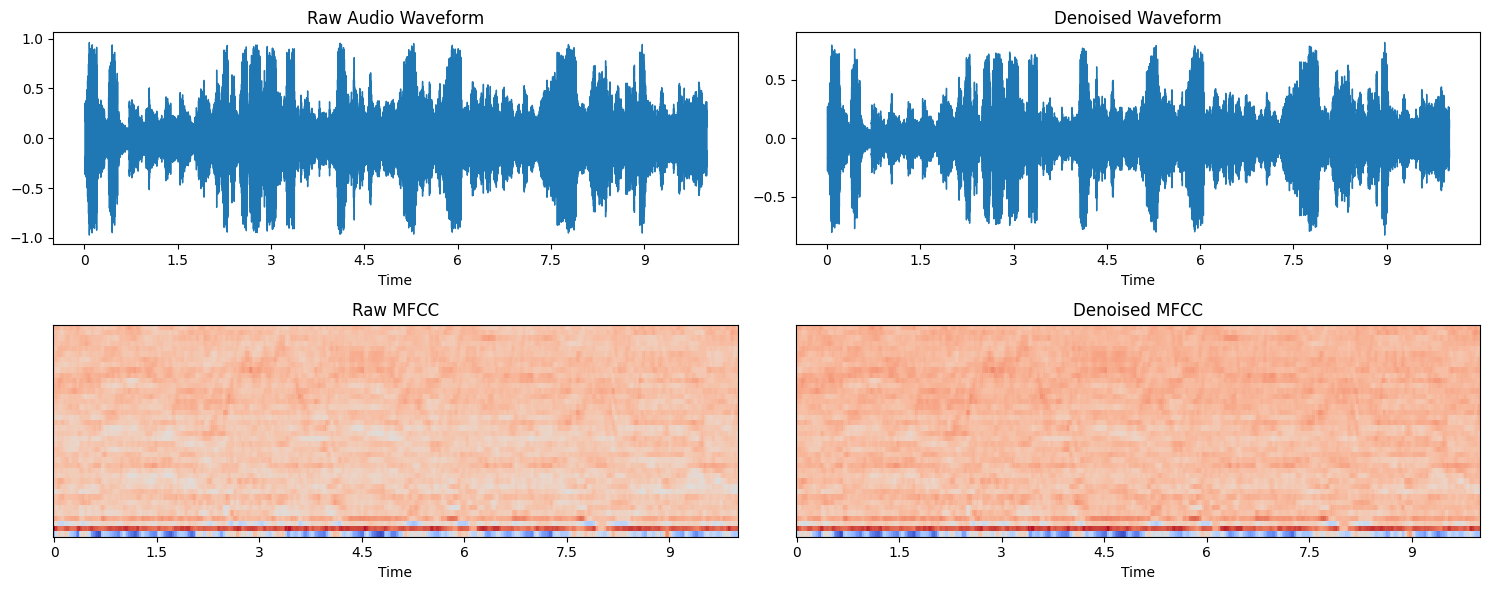

In [8]:
def visualize_processing_pipeline():
    sample_path = os.path.join(train_dir, os.listdir(train_dir)[0],
                               os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
    y_raw, _ = librosa.load(sample_path, sr=SR)
    y_clean = denoise_audio(y_raw, SR)

    plt.figure(figsize=(15, 6))

    # Waveform
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y_raw, sr=SR)
    plt.title('Raw Audio Waveform')

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(y_clean, sr=SR)
    plt.title('Denoised Waveform')

    # MFCC Comparison
    plt.subplot(2, 2, 3)
    mfcc_raw = librosa.feature.mfcc(y=y_raw, sr=SR, n_mfcc=40)
    librosa.display.specshow(mfcc_raw, x_axis='time')
    plt.title('Raw MFCC')

    plt.subplot(2, 2, 4)
    mfcc_clean = librosa.feature.mfcc(y=y_clean, sr=SR, n_mfcc=40)
    librosa.display.specshow(mfcc_clean, x_axis='time')
    plt.title('Denoised MFCC')
    plt.tight_layout()

    nama_file_cm = 'denoising.png'
    path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)
    
    try:
        plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
        print(f"Berhasil disimpan")
    except Exception as e:
        print(f"Gagal menyimpan")

    
    plt.show()

# Jalankan visualisasi pipeline
print("Visualisasi Proses Preprocessing:")
visualize_processing_pipeline()

Visualisasi Teknik Augmentasi Gamelan:
Berhasil disimpan


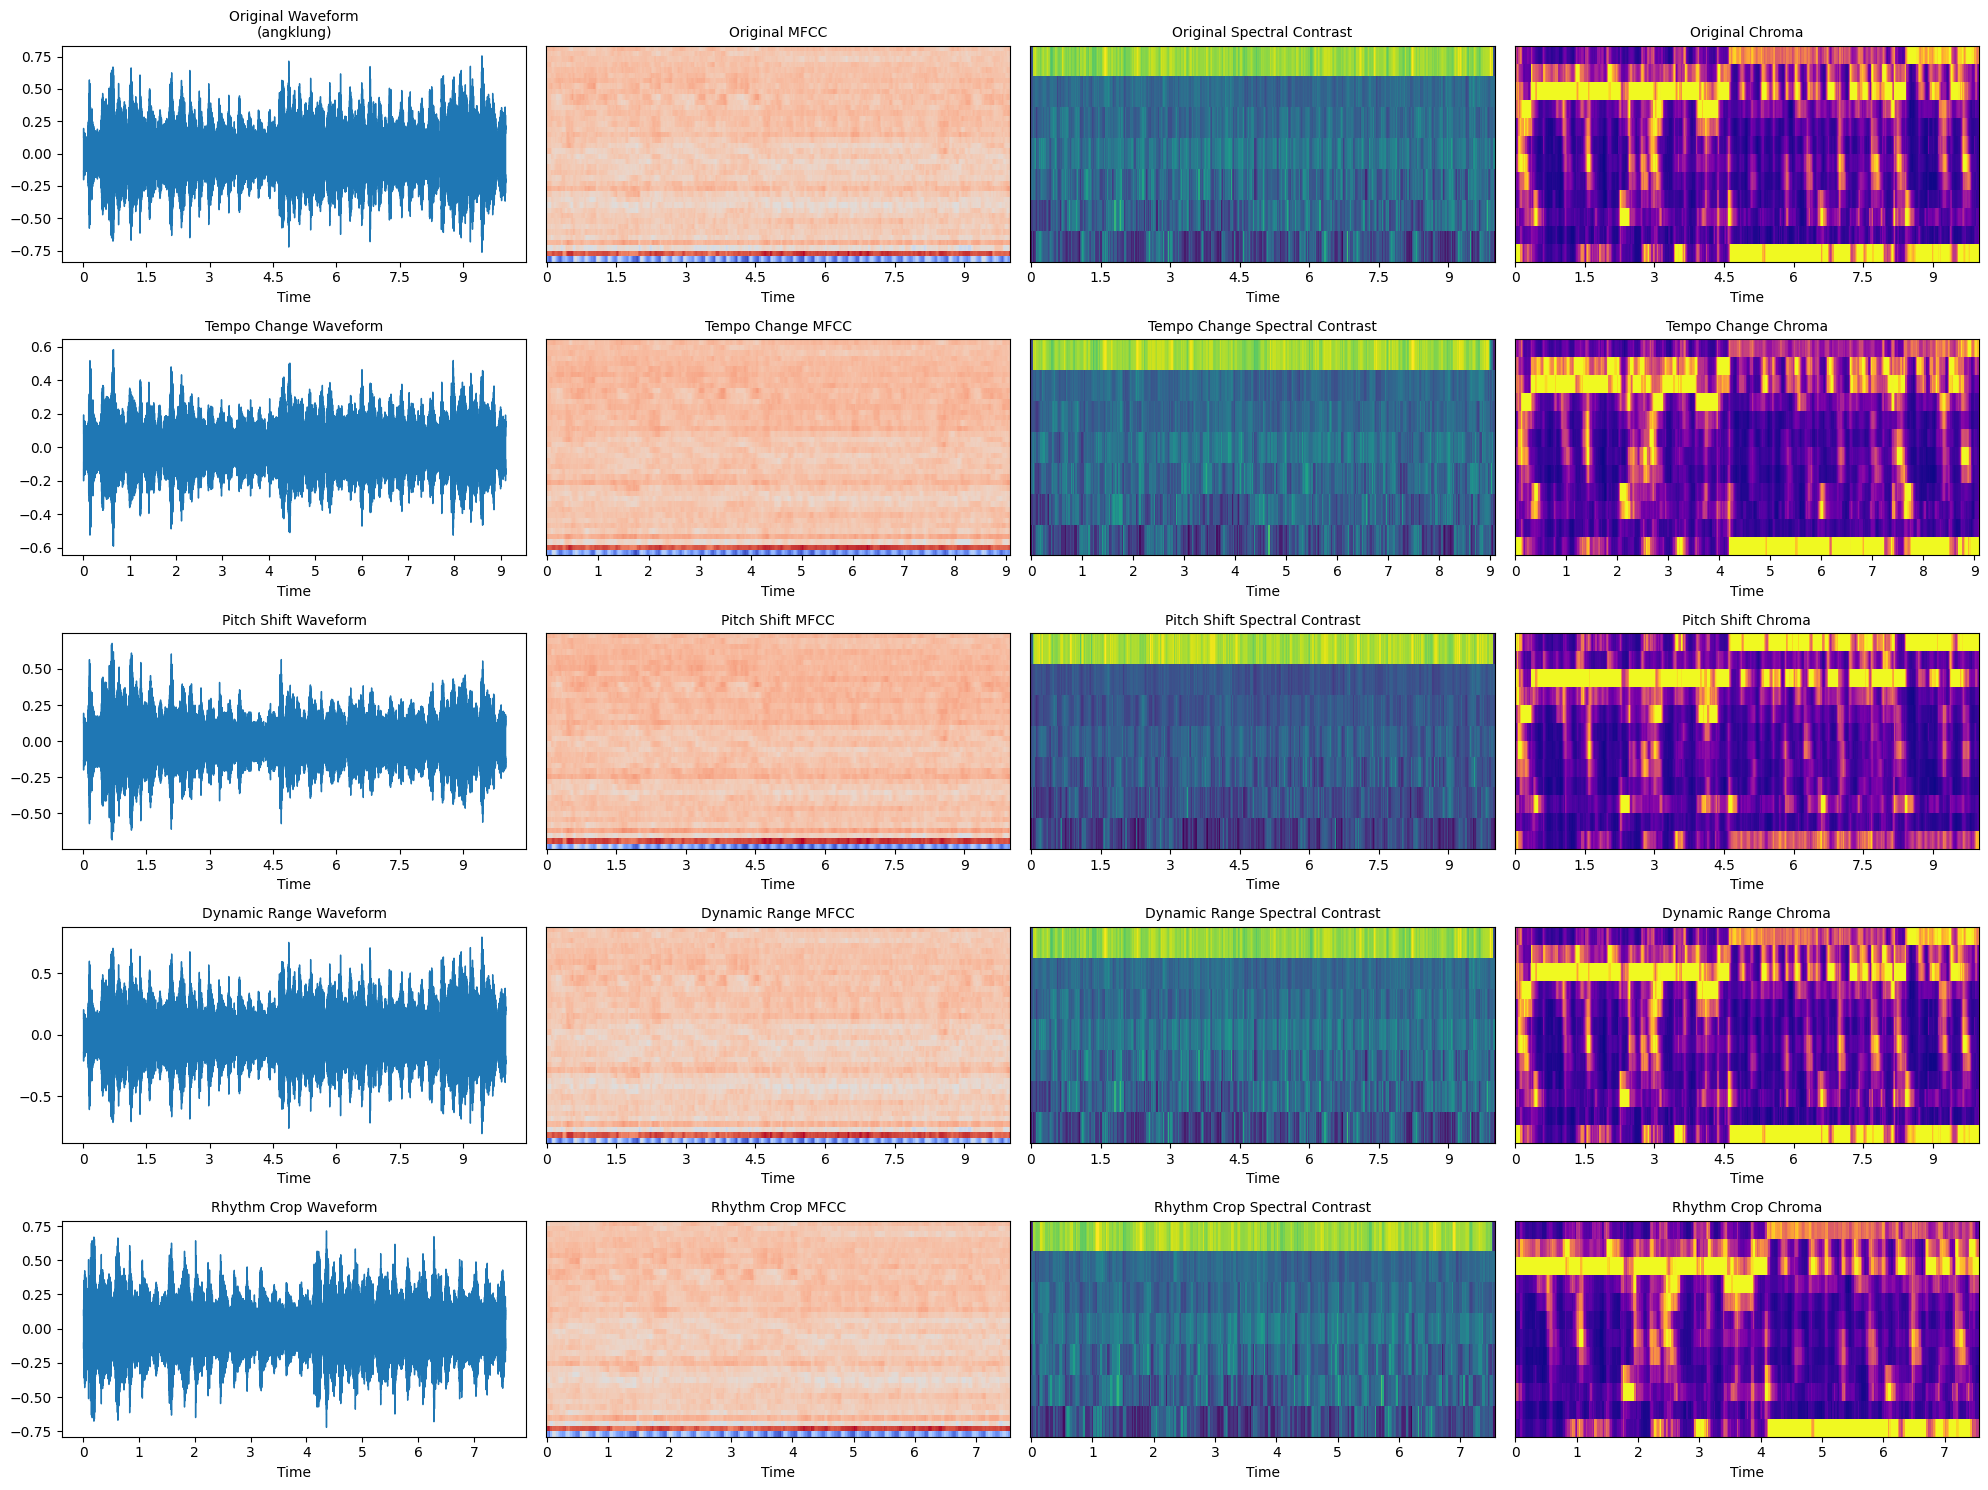

In [9]:
def visualize_gamelan_augmentations():
    # Ambil sample audio
    sample_cls = random.choice(os.listdir(train_dir))
    sample_path = os.path.join(train_dir, sample_cls, random.choice(os.listdir(os.path.join(train_dir, sample_cls))))
    y, sr = librosa.load(sample_path, sr=SR)

    plt.figure(figsize=(20, 15))

    plt.subplot(5, 4, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Original Waveform\n({sample_cls})', fontsize=10)

    plt.subplot(5, 4, 2)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    librosa.display.specshow(mfcc, x_axis='time', cmap='coolwarm')
    plt.title('Original MFCC', fontsize=10)

    plt.subplot(5, 4, 3)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    librosa.display.specshow(spectral_contrast, x_axis='time', cmap='viridis')
    plt.title('Original Spectral Contrast', fontsize=10)

    plt.subplot(5, 4, 4)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    librosa.display.specshow(chroma, x_axis='time', cmap='plasma')
    plt.title('Original Chroma', fontsize=10)

    # Augmentasi dan visualisasi
    augmentations = [
        ('Tempo Change', tempo_preserve_pitch),
        ('Pitch Shift', gamelan_pitch_shift),
        ('Dynamic Range', dynamic_range_augmentation),
        ('Rhythm Crop', cyclic_rhythm_crop)
    ]

    for row, (title, aug_func) in enumerate(augmentations, 2):
        y_aug = aug_func(y.copy(), sr)

        # Waveform
        plt.subplot(5, 4, row*4-3)
        librosa.display.waveshow(y_aug, sr=sr)
        plt.title(f'{title} Waveform', fontsize=10)

        # MFCC
        plt.subplot(5, 4, row*4-2)
        mfcc_aug = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=40)
        librosa.display.specshow(mfcc_aug, x_axis='time', cmap='coolwarm')
        plt.title(f'{title} MFCC', fontsize=10)

        # Spectral Contrast
        plt.subplot(5, 4, row*4-1)
        spectral_contrast_aug = librosa.feature.spectral_contrast(y=y_aug, sr=sr)
        librosa.display.specshow(spectral_contrast_aug, x_axis='time', cmap='viridis')
        plt.title(f'{title} Spectral Contrast', fontsize=10)

        # Chroma
        plt.subplot(5, 4, row*4)
        chroma_aug = librosa.feature.chroma_cqt(y=y_aug, sr=sr)
        librosa.display.specshow(chroma_aug, x_axis='time', cmap='plasma')
        plt.title(f'{title} Chroma', fontsize=10)

    plt.tight_layout()
    nama_file_cm = 'augmentasi.png'
    path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)
    
    try:
        plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
        print(f"Berhasil disimpan")
    except Exception as e:
        print(f"Gagal menyimpan")
    
    plt.show()

print("Visualisasi Teknik Augmentasi Gamelan:")
visualize_gamelan_augmentations()

Membuat plot distribusi data Training dan Validasi...
Berhasil disimpan di E:/RISVA/audio_model/model_logs/V13_fix_ast\class_distributions.png


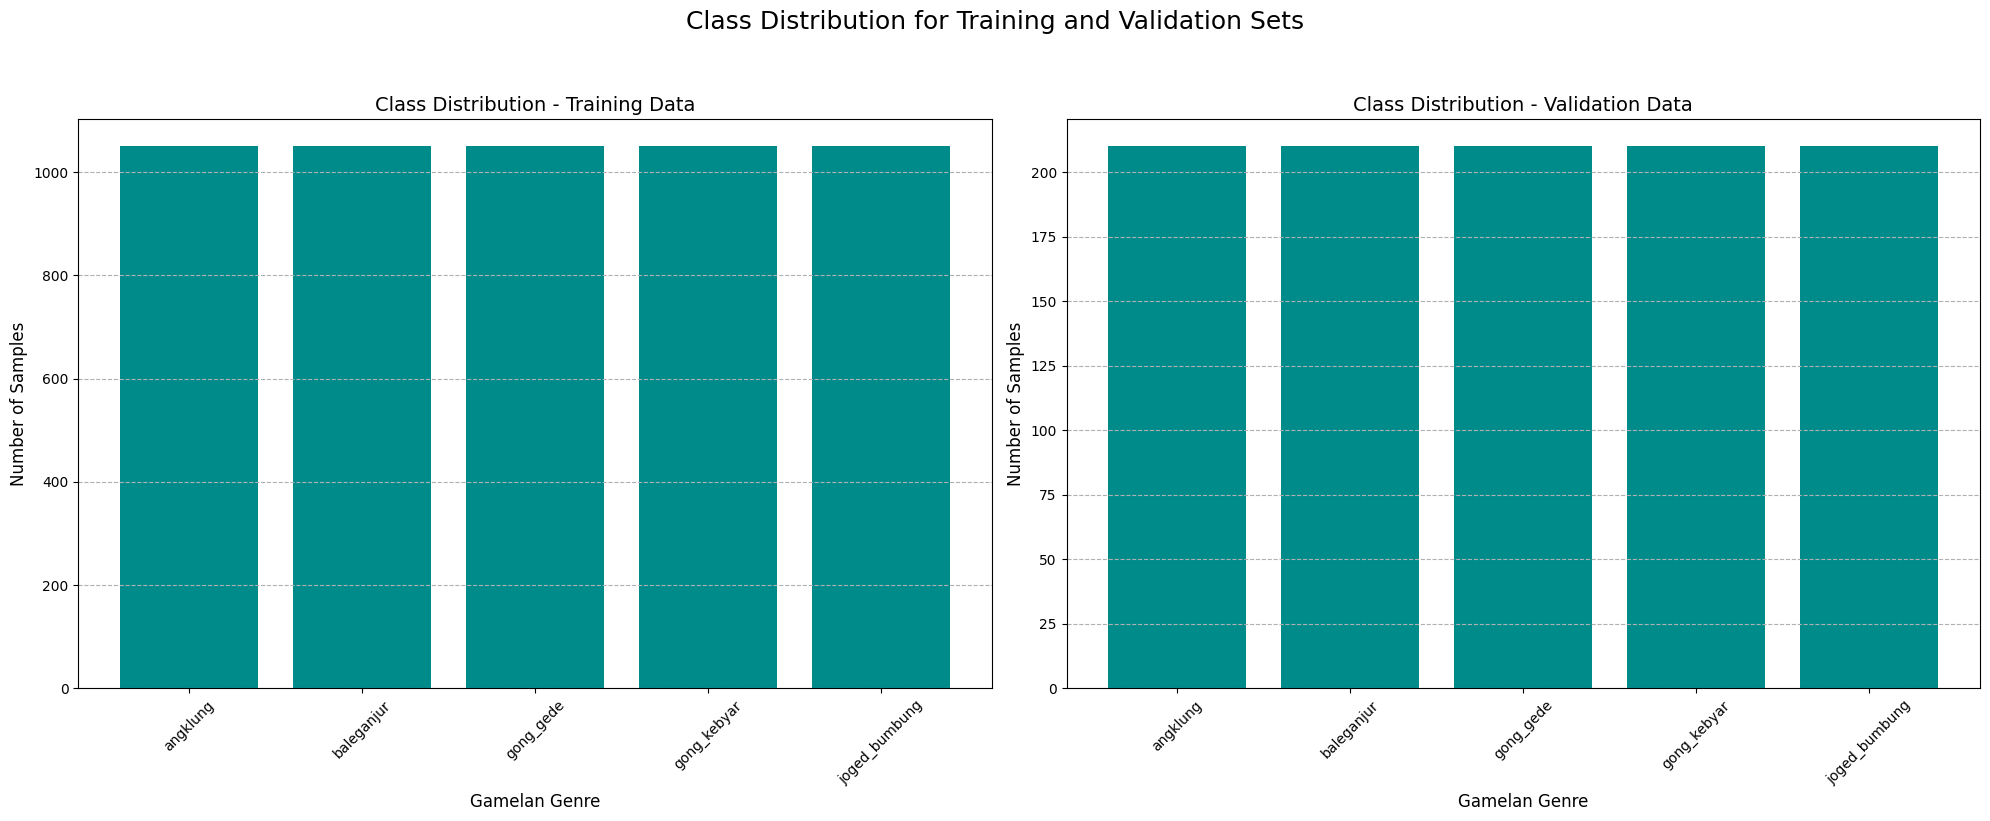

<Figure size 640x480 with 0 Axes>

In [10]:
#visualisai distirbusi kelas
def plot_class_distribution_on_ax(ax, directory, title):
    class_counts = {}
    if not os.path.isdir(directory):
        ax.text(0.5, 0.5, f"Direktori tidak ditemukan:\n{directory}", 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, color='red')
        ax.set_title(f'Error - {title}', fontsize=14)
        return

    classes = sorted(os.listdir(directory))
    if not classes:
        ax.text(0.5, 0.5, f"Tidak ada kelas ditemukan di:\n{directory}", 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, color='orange')
        ax.set_title(f'Data Kosong - {title}', fontsize=14)
        return

    for cls_name in classes: 
        cls_path = os.path.join(directory, cls_name)
        if os.path.isdir(cls_path):
            try:
                num_files = len([name for name in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, name))])
                class_counts[cls_name] = num_files
            except Exception as e:
                print(f"Tidak bisa mengakses direktori {cls_path}: {e}")
                class_counts[cls_name] = 0 
        else:
            pass 
    
    if not class_counts:
        ax.text(0.5, 0.5, f"Tidak ada data sampel ditemukan di kelas-kelas dalam:\n{directory}", 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, color='orange')
        ax.set_title(f'Data Sampel Kosong - {title}', fontsize=14)
        return

    ax.bar(class_counts.keys(), class_counts.values(), color='darkcyan')
    ax.set_title(f'Class Distribution - {title}', fontsize=14)
    ax.set_xlabel('Gamelan Genre', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10) 
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--')


print("Membuat plot distribusi data Training dan Validasi...")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8)) 

plot_class_distribution_on_ax(ax1, train_dir, "Training Data")
plot_class_distribution_on_ax(ax2, val_dir, "Validation Data") 


fig.suptitle('Class Distribution for Training and Validation Sets', fontsize=18, y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.98]) 

nama_file_dist_gabungan = 'class_distributions.png'
path_simpan_dist_gabungan = os.path.join(save_model_dir, nama_file_dist_gabungan)

try:
    plt.savefig(path_simpan_dist_gabungan, dpi=300, bbox_inches='tight') 
    print(f"Berhasil disimpan di {path_simpan_dist_gabungan}")
except Exception as e:
    print(f"Gagal menyimpan plot distribusi: {e}")

plt.show() 

plt.clf() 
plt.close(fig)

Berhasil disimpan


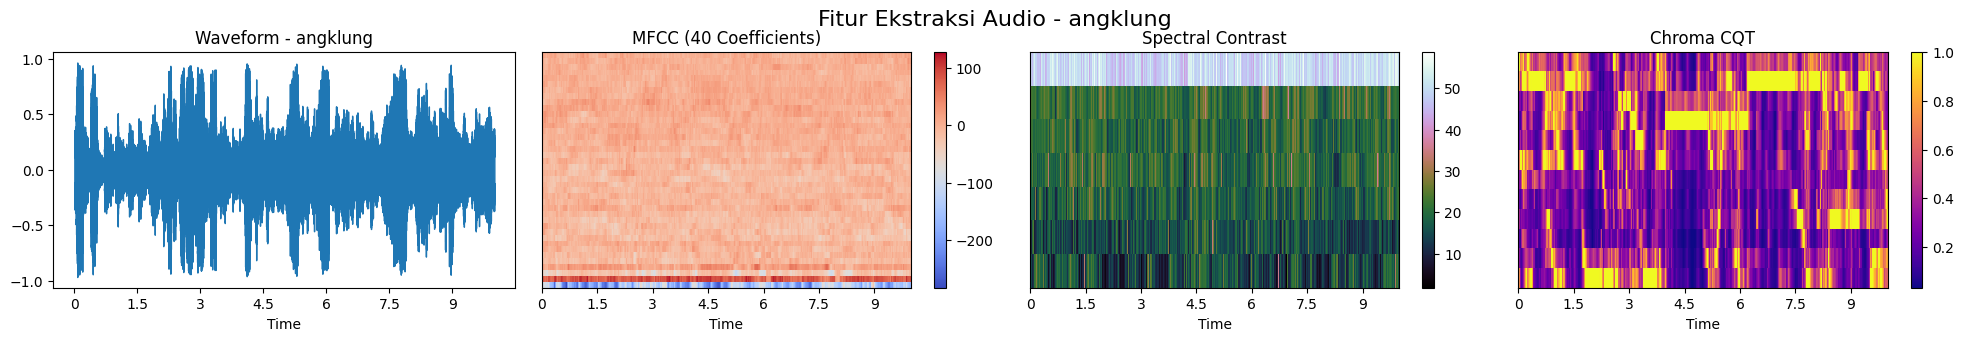

Berhasil disimpan


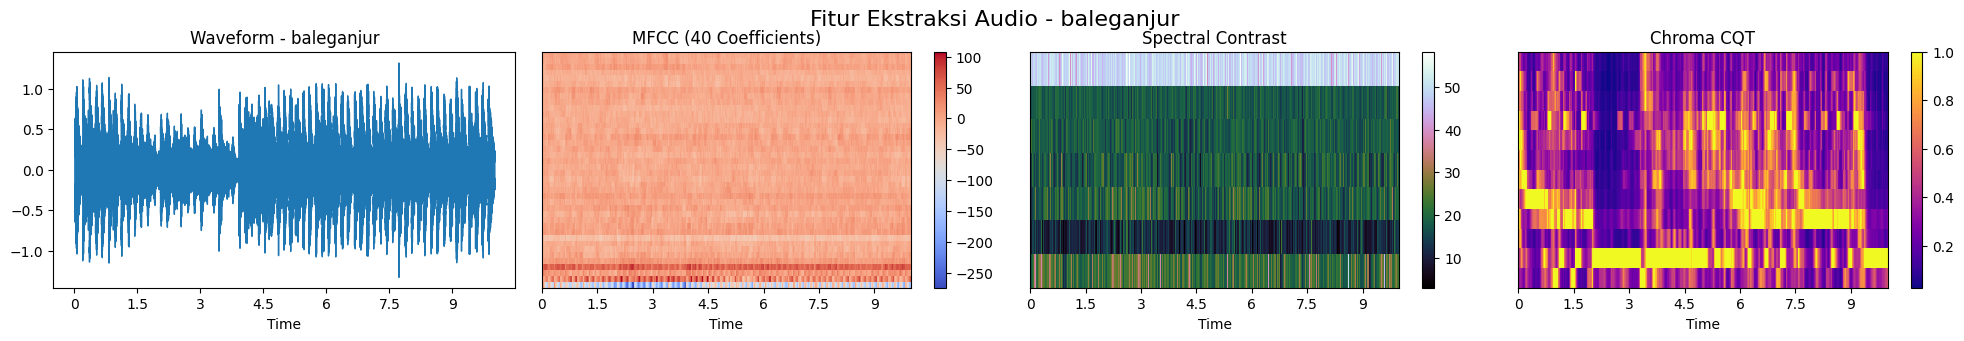

Berhasil disimpan


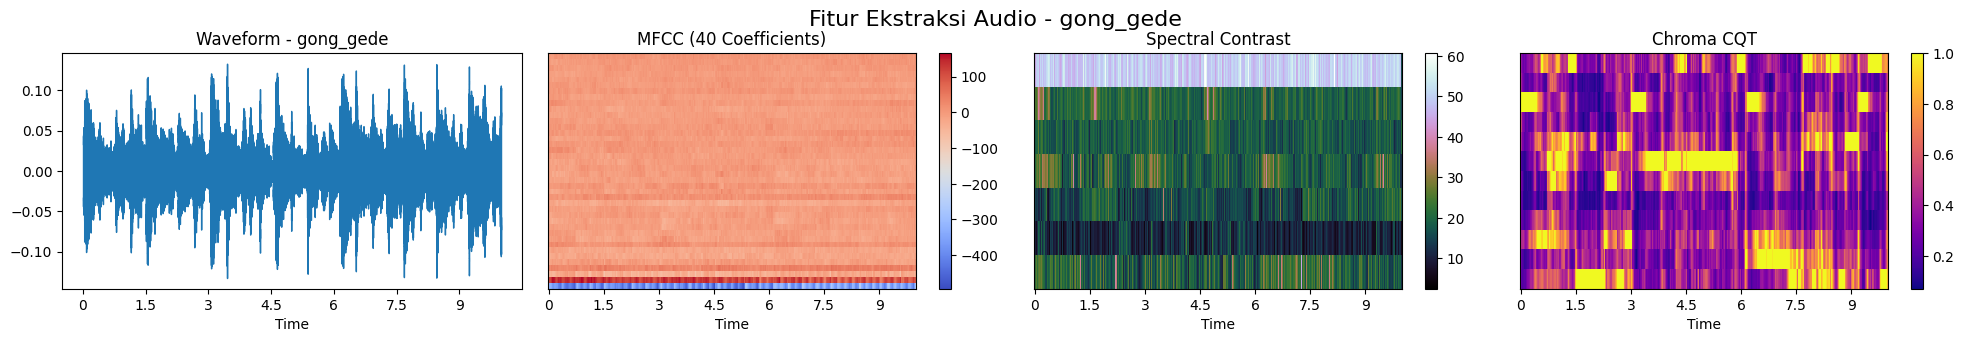

Berhasil disimpan


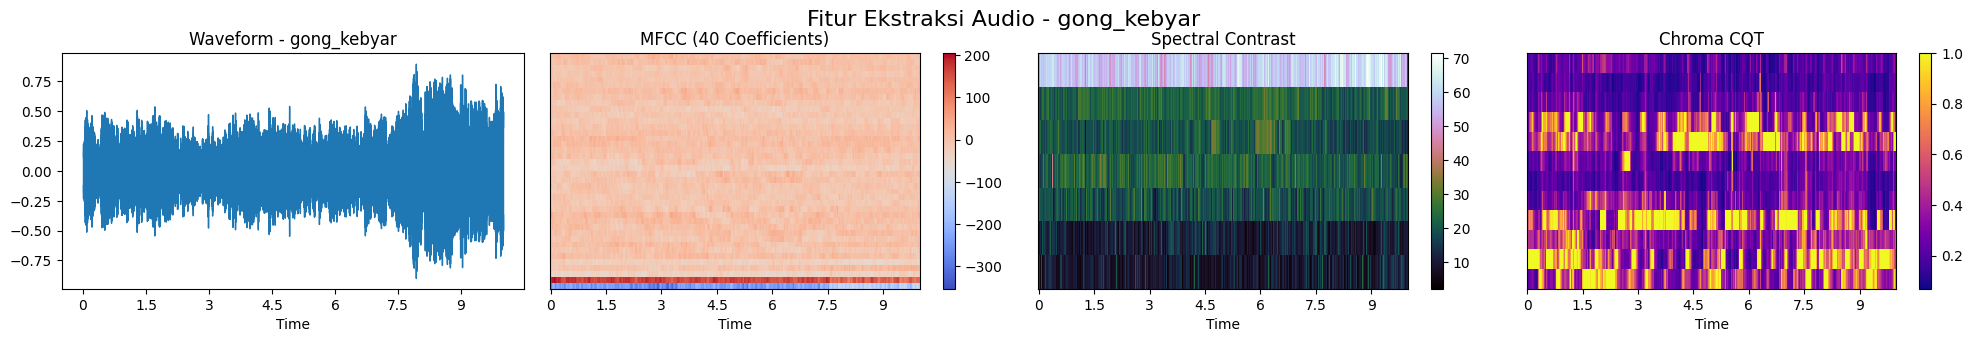

Berhasil disimpan


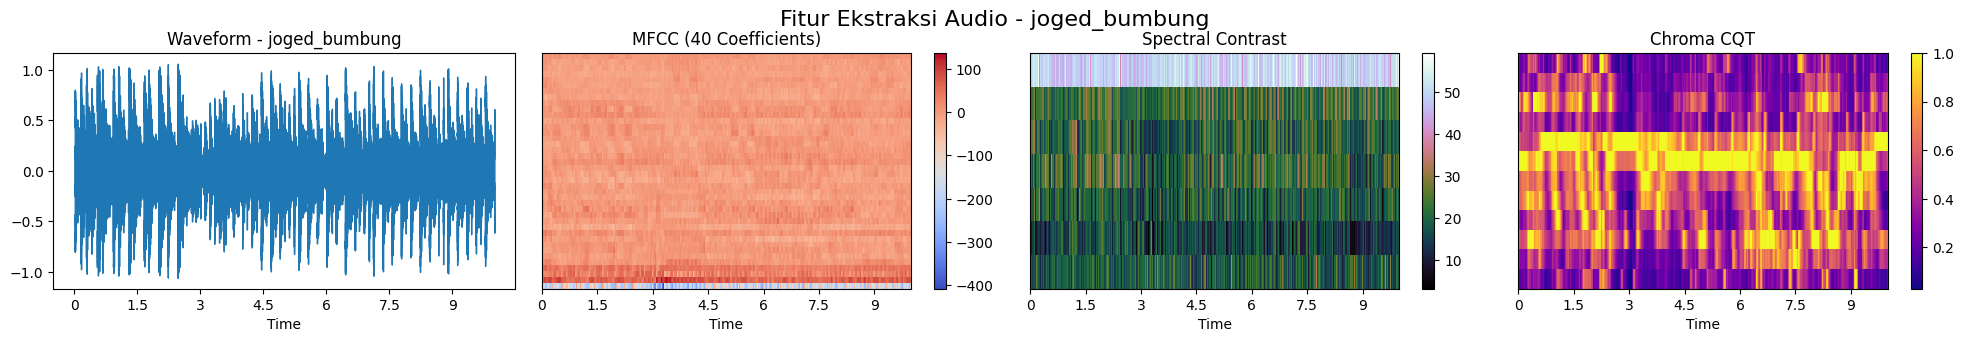

In [11]:
def plot_audio_features(file_path, class_name):
    y, sr = librosa.load(file_path, sr=SR)

    # Ekstraksi fitur
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=HOP_LENGTH)

    # Plotting
    plt.figure(figsize=(20, 15))

    plt.subplot(5, 4, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {class_name}')

    plt.subplot(5, 4, 2)
    librosa.display.specshow(mfcc, x_axis='time', cmap='coolwarm', sr=sr, hop_length=HOP_LENGTH)
    plt.colorbar()
    plt.title(f'MFCC ({N_MFCC} Coefficients)')

    plt.subplot(5, 4, 3)
    librosa.display.specshow(spectral_contrast, x_axis='time', sr=sr, cmap='cubehelix', hop_length=HOP_LENGTH)
    plt.colorbar()
    plt.title('Spectral Contrast')

    plt.subplot(5, 4, 4)
    librosa.display.specshow(chroma, x_axis='time', sr=sr, cmap='plasma', hop_length=HOP_LENGTH)
    plt.colorbar()
    plt.title('Chroma CQT')

    plt.suptitle(f'Fitur Ekstraksi Audio - {class_name}', fontsize=16)
    plt.tight_layout()
    nama_file_cm = 'Ekstraksi fitur.png'
    path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)
    
    try:
        plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
        print(f"Berhasil disimpan")
    except Exception as e:
        print(f"Gagal menyimpan")

    plt.show()

for cls in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        sample_files = [f for f in os.listdir(class_path) if f.endswith(('.wav', '.mp3'))]
        if sample_files:
            plot_audio_features(os.path.join(class_path, sample_files[0]), cls)


Processing gong_kebyar: 100%|██████████| 100/100 [00:13<00:00,  7.58it/s]
C:\User\Legion\AppData\Local\Temp\ipykernel_18452\2199053048.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feat, data=df, palette='Set2')
C:\User\Legion\AppData\Local\Temp\ipykernel_18452\2199053048.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feat, data=df, palette='Set2')
C:\User\Legion\AppData\Local\Temp\ipykernel_18452\2199053048.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feat, data=df, palett

C:\User\Legion\AppData\Local\Temp\ipykernel_18452\2199053048.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y=feat, data=df, palette='Set2')


Berhasil disimpan


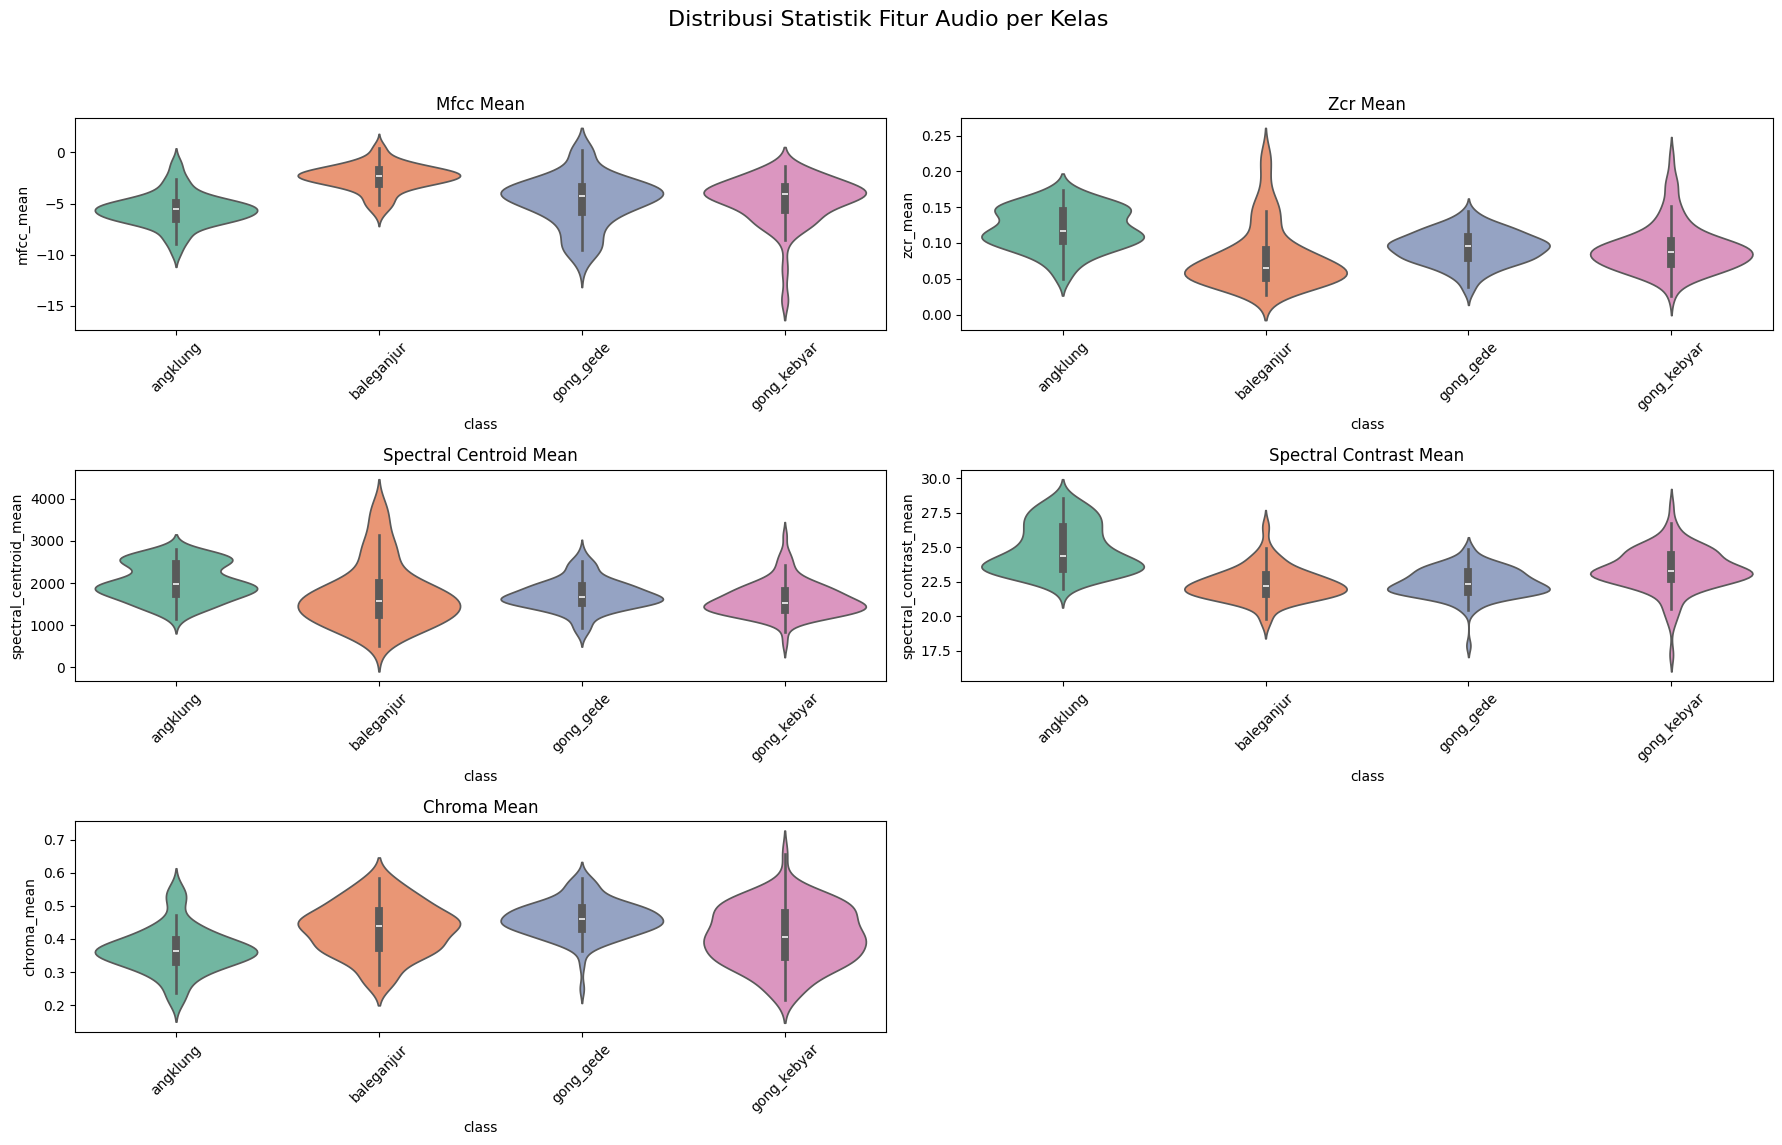

In [ ]:
def extract_analysis_features(file_path):
    y, sr = librosa.load(file_path, sr=SR)

    # Ekstraksi fitur dasar
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC,
                                n_fft=N_FFT, hop_length=HOP_LENGTH)
    zcr = librosa.feature.zero_crossing_rate(y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr,
                                                          n_fft=N_FFT,
                                                          hop_length=HOP_LENGTH)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr,
                                                          n_fft=N_FFT,
                                                          hop_length=HOP_LENGTH)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr,
                                        hop_length=HOP_LENGTH)

    # Statistik per fitur
    features = {
        'mfcc_mean': np.mean(mfcc),
        'mfcc_std': np.std(mfcc),
        'zcr_mean': np.mean(zcr),
        'spectral_centroid_mean': np.mean(spectral_centroid),
        'spectral_contrast_mean': np.mean(spectral_contrast),
        'spectral_contrast_std': np.std(spectral_contrast),
        'chroma_mean': np.mean(chroma),
        'chroma_std': np.std(chroma)
    }
    return features

# Load data dan ekstraksi
classes = ['angklung', 'baleganjur', 'gong_gede', 'gong_kebyar', 'joged_bumbung']
analysis_data = []
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    if os.path.exists(cls_path):
        for fn in tqdm(os.listdir(cls_path)[:100], desc=f"Processing {cls}"):
            if fn.lower().endswith(('.mp3', '.wav')):
                feats = extract_analysis_features(os.path.join(cls_path, fn))
                feats['class'] = cls
                analysis_data.append(feats)
    else:
        print(f"Warning: Directory not found: {cls_path}")

df = pd.DataFrame(analysis_data)

# Plot distribusi statistik fitur audio per kelas
plt.figure(figsize=(18, 12))
features_to_plot = [
    'mfcc_mean', 'zcr_mean',
    'spectral_centroid_mean', 'spectral_contrast_mean', 'chroma_mean'
]
for i, feat in enumerate(features_to_plot):
    plt.subplot(3, 2, i + 1)
    sns.violinplot(x='class', y=feat, data=df, palette='Set2')
    plt.title(feat.replace('_', ' ').title(), fontsize=12)
    plt.xticks(rotation=45)

plt.suptitle("Distribusi Statistik Fitur Audio per Kelas", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
nama_file_cm = 'distribusi statistik audio.png'
path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)
    
try:
    plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
    print(f"Berhasil disimpan")
except Exception as e:
    print(f"Gagal menyimpan")

plt.show()

## 6. Persiapan Dataset


    

In [13]:
# Load data
print("Memuat data training...")
X_train, y_train = load_dataset(train_dir, augment=True)
print("\nMemuat data validasi...")
X_val, y_val = load_dataset(val_dir, augment=False)

# Encode labels
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_val_enc = encoder.transform(y_val)

# Convert to one-hot
y_train_cat = tf.keras.utils.to_categorical(y_train_enc, len(encoder.classes_))
y_val_cat = tf.keras.utils.to_categorical(y_val_enc, len(encoder.classes_))

Memuat data training...


Loading angklung:   7%|▋         | 69/1050 [00:24<05:52,  2.78it/s]


KeyboardInterrupt: 

## 7. Bangun Arsitektur ConvLSTM

In [ ]:
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Block 1
    x = layers.ConvLSTM2D(
        64,
        kernel_size=(3, 3),
        activation='tanh',
        padding='same',
        return_sequences=False,
        kernel_regularizer=regularizers.l2(L2_REG)
    )(inputs)

    # Block 2
    x = layers.Conv2D(
        128,
        kernel_size=(3, 1),
        activation='relu',
        padding='valid',
        kernel_regularizer=regularizers.l2(L2_REG)
    )(x)

    # Block 3: Max pooling
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Block 4: Flatten + Dense
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

## 8. Inisialisasi Model


In [ ]:
model = build_model(X_train.shape[1:], len(encoder.classes_))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.AUC(name='auc')]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 432, 59, 1, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 59, 1, 64)      │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,877 (749.52 KB)

 Trainable params: 191,877 (749.52 KB)

 Non-trainable params: 0 (0.00 B)

## 10. Train Model & Callbacks


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        os.path.join(save_model_dir, 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
    CSVLogger(
        os.path.join(save_model_dir, 'training_log.csv'),
    )
]


In [ ]:
# import os
# import pandas as pd
# from tensorflow.keras.models import load_model

# # Path
# model_path = os.path.join(save_model_dir, 'best_model.keras')
# log_path = os.path.join(save_model_dir, 'training_log.csv')

# # Load latest model
# model = load_model(model_path)

# if os.path.exists(log_path): 
#     log_df = pd.read_csv(log_path)
#     initial_epoch = len(log_df)
# else:
#     initial_epoch = 0

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    batch_size=BATCH_SIZE,
    # initial_epoch=,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 480s 3s/step - accuracy: 0.1924 - auc: 0.5046 - loss: 1.6178 - precision: 0.0000e+00 - val_accuracy: 0.2010 - val_auc: 0.5432 - val_loss: 1.6137 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.2315 - auc: 0.5374 - loss: 1.6116 - precision: 0.0000e+00 - val_accuracy: 0.2276 - val_auc: 0.5808 - val_loss: 1.5869 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.2928 - auc: 0.6308 - loss: 1.5371 - precision: 0.4405 - val_accuracy: 0.3924 - val_auc: 0.7416 - val_loss: 1.3894 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.3607 - auc: 0.7106 - loss: 1.4288 - precision: 0.5628 - val_accuracy: 0.4333 - val_auc: 0.7550 - val_loss: 1.3327 - val_precision: 0.6679 - learning_rate: 1.0000e-04
Epoch 5/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 449

KeyboardInterrupt: 

## 11. Evaluasi & Visualisasi Hasil


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 808ms/step
Confusion matrix berhasil disimpan di: E:/RISVA/audio_model/model_logs/v9_NoAugment10s\confusion_matrix.png


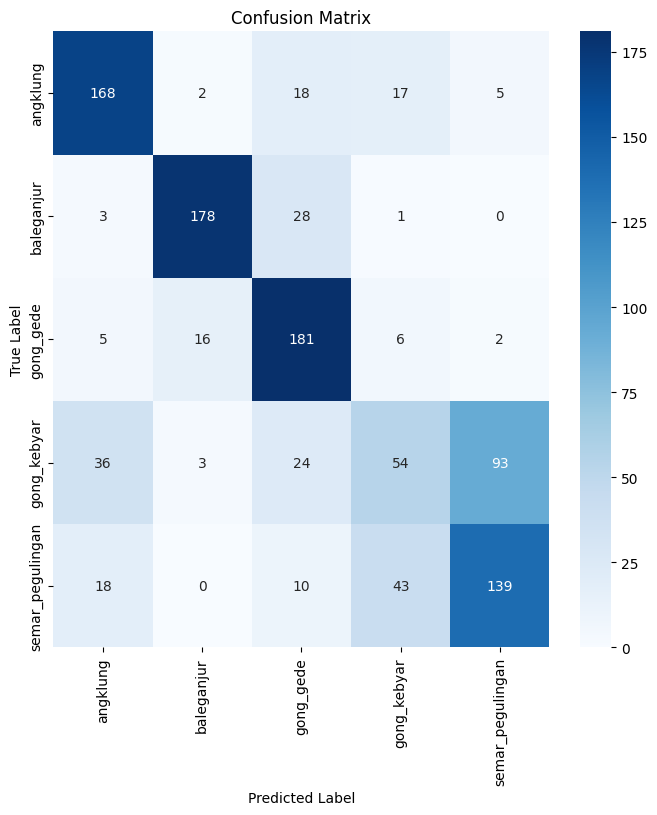


Classification Report:
                  precision    recall  f1-score   support

        angklung       0.73      0.80      0.76       210
      baleganjur       0.89      0.85      0.87       210
       gong_gede       0.69      0.86      0.77       210
     gong_kebyar       0.45      0.26      0.33       210
semar_pegulingan       0.58      0.66      0.62       210

        accuracy                           0.69      1050
       macro avg       0.67      0.69      0.67      1050
    weighted avg       0.67      0.69      0.67      1050

Classification report berhasil disimpan di: E:/RISVA/audio_model/model_logs/v9_NoAugment10s\classification_report.txt


In [ ]:
# Confusion Matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

plt.figure(figsize=(8,8))
cm = tf.math.confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

nama_file_cm = 'confusion_matrix.png'
path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)

try:
    plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
    print(f"Confusion matrix berhasil disimpan di: {path_simpan_cm}")
except Exception as e:
    print(f"Gagal menyimpan confusion matrix: {e}")

plt.show()

# Classification Report
from sklearn.metrics import classification_report
report_text = classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_)
print("\nClassification Report:")
print(report_text)

nama_file_report = 'classification_report.txt'
path_simpan_report = os.path.join(save_model_dir, nama_file_report)
try:
    with open(path_simpan_report, 'w') as f:
        f.write("Classification Report:\n")
        f.write(report_text)
    print(f"Classification report berhasil disimpan di: {path_simpan_report}")
except Exception as e:
    print(f"Gagal menyimpan classification report: {e}")

Plot berhasil disimpan di: E:/RISVA/audio_model/model_logs/v9_NoAugment10s\plot.png


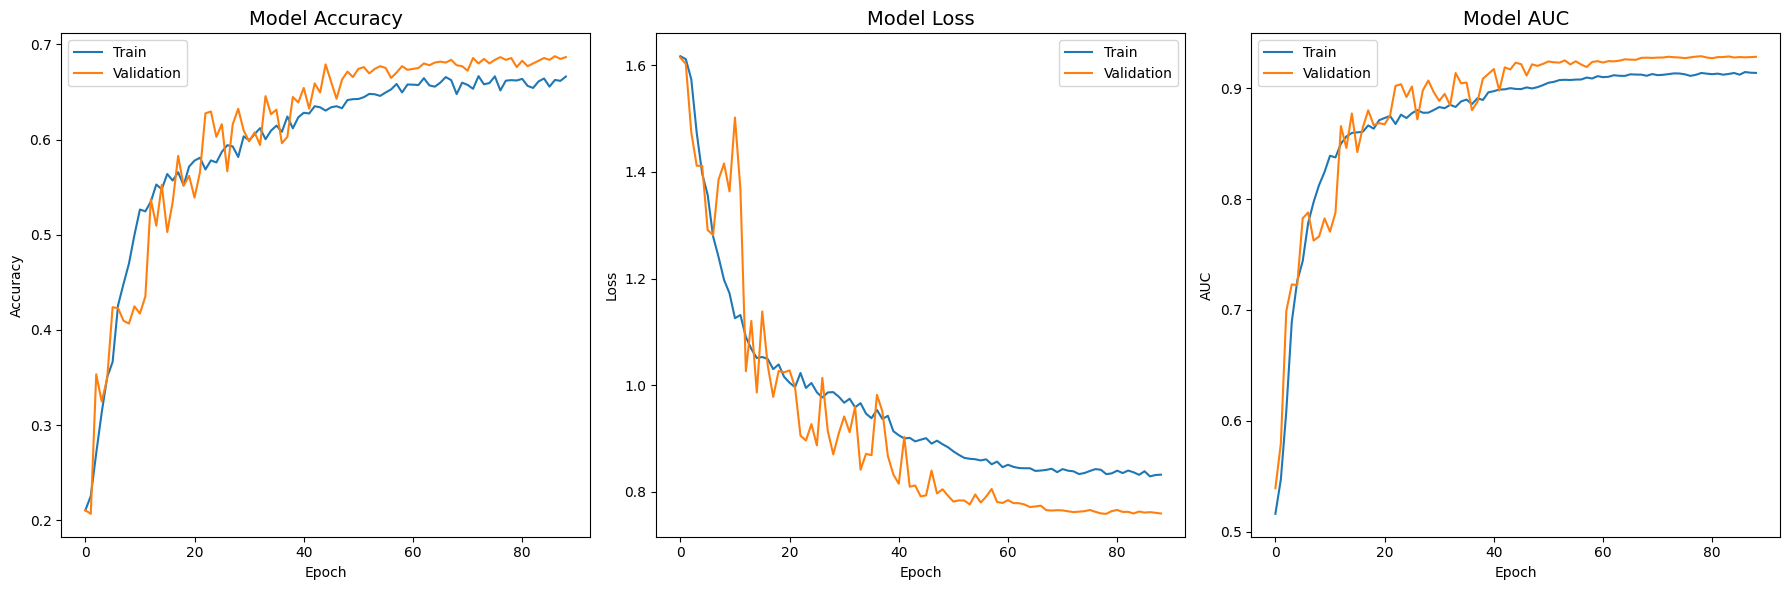

In [ ]:
# Plot Training History
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# AUC Plot
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('Model AUC', fontsize=14)
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
nama_file_cm = 'plot.png'
path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)

try:
    plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
    print(f"Plot berhasil disimpan di: {path_simpan_cm}")
except Exception as e:
    print(f"Gagal menyimpan plot: {e}")
plt.show()


Visualisasi Prediksi per Kelas (3 Sample per Kelas):
Visualisasi prediksi berhasil disimpan di: E:/RISVA/audio_model/model_logs/v9_NoAugment10s\predict_val.png


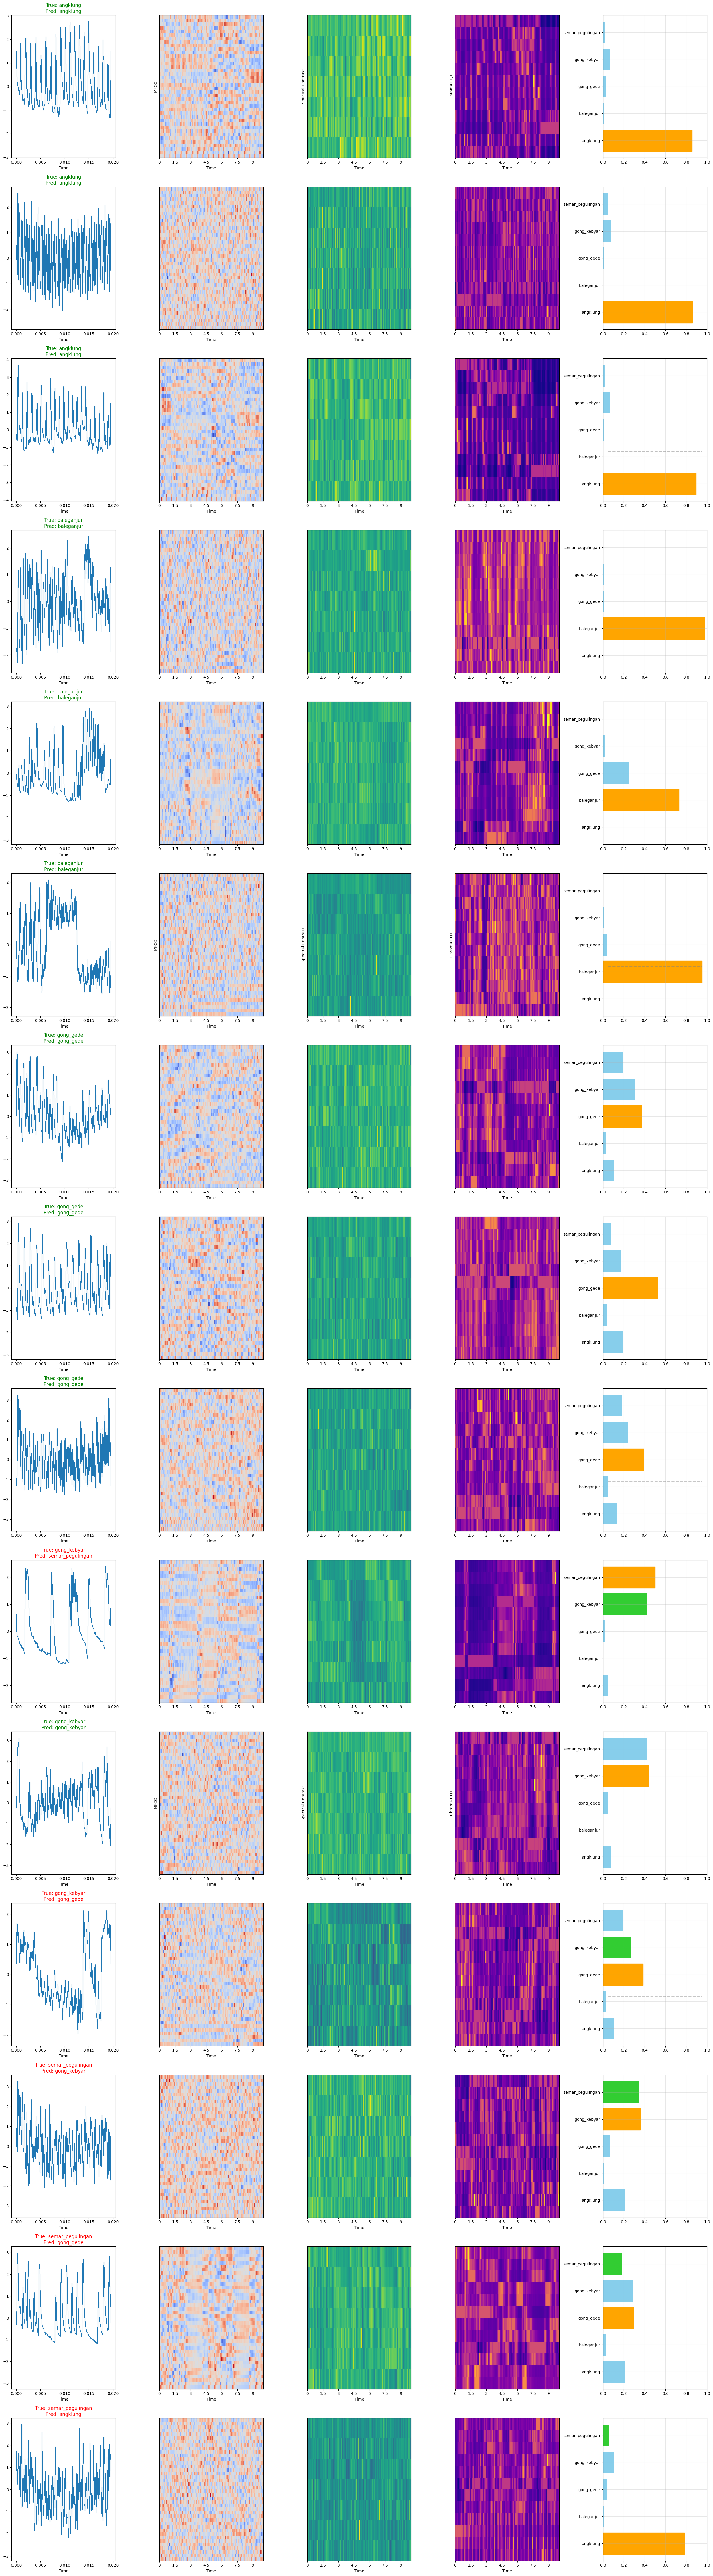

In [ ]:
def visualize_predictions(samples_per_class=3):
    classes = encoder.classes_
    num_classes = len(classes)
    total_samples = num_classes * samples_per_class

    plt.figure(figsize=(25, total_samples*6))

    class_indices = []
    true_labels = np.argmax(y_val_cat, axis=1)

    for cls_idx, cls_name in enumerate(classes):
        indices = np.where(true_labels == cls_idx)[0]
        selected = np.random.choice(indices, samples_per_class, replace=False)
        class_indices.extend(selected)

    # Plotting
    for i, idx in enumerate(class_indices, 1):
        audio = X_val[idx]
        true_label = classes[true_labels[idx]]
        pred_probs = model.predict(np.expand_dims(audio, axis=0), verbose=0)[0]
        pred_label = classes[np.argmax(pred_probs)]

        # Ekstrak fitur
        mfcc_features = audio[:, :40, 0, 0].T
        spectral_contrast = audio[:, 40:47, 0, 0].T
        chroma = audio[:, 47:59, 0, 0].T

        # Plot waveform
        plt.subplot(total_samples, 5, i*5-4)
        librosa.display.waveshow(audio[:,0,0,0], sr=SR)
        plt.title(f'True: {true_label}\nPred: {pred_label}',
                  fontsize=12, color='green' if true_label == pred_label else 'red')

        # Plot MFCC
        plt.subplot(total_samples, 5, i*5-3)
        librosa.display.specshow(mfcc_features, x_axis='time',
                                 sr=SR, hop_length=HOP_LENGTH, cmap='coolwarm')
        plt.ylabel('MFCC' if i%5 == 1 else '')

        # Plot Spectral Contrast
        plt.subplot(total_samples, 5, i*5-2)
        librosa.display.specshow(spectral_contrast, x_axis='time',
                                 sr=SR, hop_length=HOP_LENGTH, cmap='viridis')
        plt.ylabel('Spectral Contrast' if i%5 == 1 else '')

        # Plot Chroma
        plt.subplot(total_samples, 5, i*5-1)
        librosa.display.specshow(chroma, x_axis='time',
                                sr=SR, hop_length=HOP_LENGTH, cmap='plasma')
        plt.ylabel('Chroma CQT' if i%5 == 1 else '')

        # Plot probabilitas
        plt.subplot(total_samples, 5, i*5)
        bars = plt.barh(classes, pred_probs, color=['limegreen' if c == true_label else 'skyblue' for c in classes])
        bars[np.argmax(pred_probs)].set_color('orange')
        plt.xlim(0, 1)
        plt.grid(alpha=0.3)

        if i % samples_per_class == 0 and i != total_samples:
            plt.axhline(y=1.2, color='gray', linestyle='--', linewidth=2, alpha=0.5, xmin=0.05, xmax=0.95)

    plt.tight_layout()
    nama_file_cm = 'predict_val.png'
    path_simpan_cm = os.path.join(save_model_dir, nama_file_cm)

    try:
        plt.savefig(path_simpan_cm, dpi=300, bbox_inches='tight') 
        print(f"Visualisasi prediksi berhasil disimpan di: {path_simpan_cm}")
    except Exception as e:
        print(f"Gagal menyimpan Visualisasi prediksi: {e}")
    plt.show()

print("\nVisualisasi Prediksi per Kelas (3 Sample per Kelas):")
visualize_predictions()